Import all Library

In [34]:
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


Load the data set

In [35]:

DATASET_DIR = r'D:\face-musk-data'
CATEGORIES = []
for c in os.listdir(DATASET_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['without_mask', 'with_mask']


In [36]:
# defining train test valid split
TRAIN_TEST_VALID_SPLIT = [0.7, 0.2, 0.1]
IMG_SIZE = 227
def train_test_valid_split(X , y, split):
    train_size = int(split[0] * len(X))
    test_size = int(split[1] * len(X))
    valid_size = int(split[2] * len(X))
    X_train, X_test, X_valid = X[:train_size], X[train_size:train_size+test_size], X[train_size+test_size:train_size+test_size+valid_size]
    y_train, y_test, y_valid = y[:train_size], y[train_size:train_size+test_size], y[train_size+test_size:train_size+test_size+valid_size]

    print("Train size: ", len(X_train), len(y_train))
    print("Test size: ", len(X_test), len(y_test))
    print("Valid size: ", len(X_valid), len(y_valid))

    return X_train, X_test, X_valid, y_train, y_test, y_valid





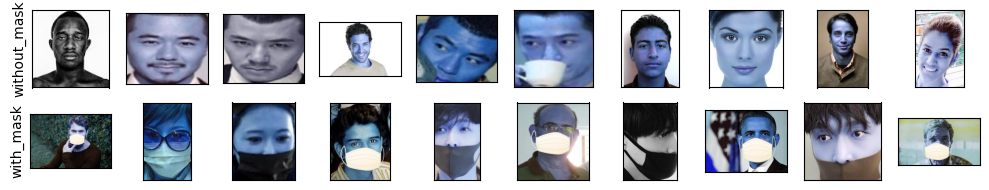

In [37]:
plt.figure(figsize=(10,2))
i=0
for c in CATEGORIES:  
    path = os.path.join(DATASET_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [38]:
datasets = []

for c in CATEGORIES:
    path = os.path.join(DATASET_DIR, c)
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            datasets.append({
                'image': img_resized,
                'label': class_num
            }) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(datasets))

100%|██████████| 3725/3725 [00:13<00:00, 271.43it/s]

7553


Shuffle the images

In [39]:
random.shuffle(datasets)

X = [i['image'] for i in datasets]
y = [i['label'] for i in datasets]

X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid_split(X, y, TRAIN_TEST_VALID_SPLIT )

Train size:  5287 5287
Test size:  1510 1510
Valid size:  755 755


In [40]:
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
y_train = np.array(y_train)

print(f"X_train= {X_train.shape} Y_train= {y_train.shape}")


X_train= (5287, 227, 227, 3) Y_train= (5287,)


In [41]:
X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

print(f"X_test= {X_test.shape} Y_test= {y_test.shape}")

X_test= (1510, 227, 227, 3) Y_test= (1510,)


Mean image of all images

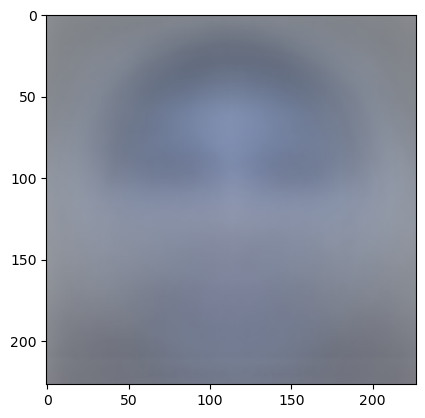

In [42]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [43]:
X_train_norm, X_valid_norm,  X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img


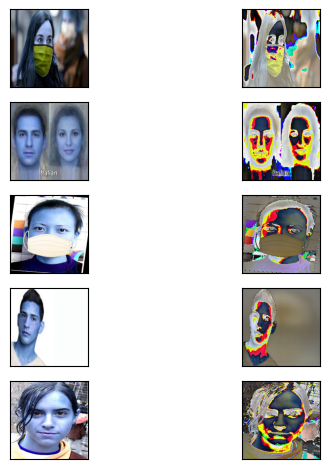

In [44]:
c = 0
# plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [45]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

 Create model


In [51]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(1),
    layers.Activation('sigmoid')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_49 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 17, 17, 256)       2973952   
                                                                 
 activation_50 (Activation)  (None, 17, 17, 256)      

In [47]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Start Training

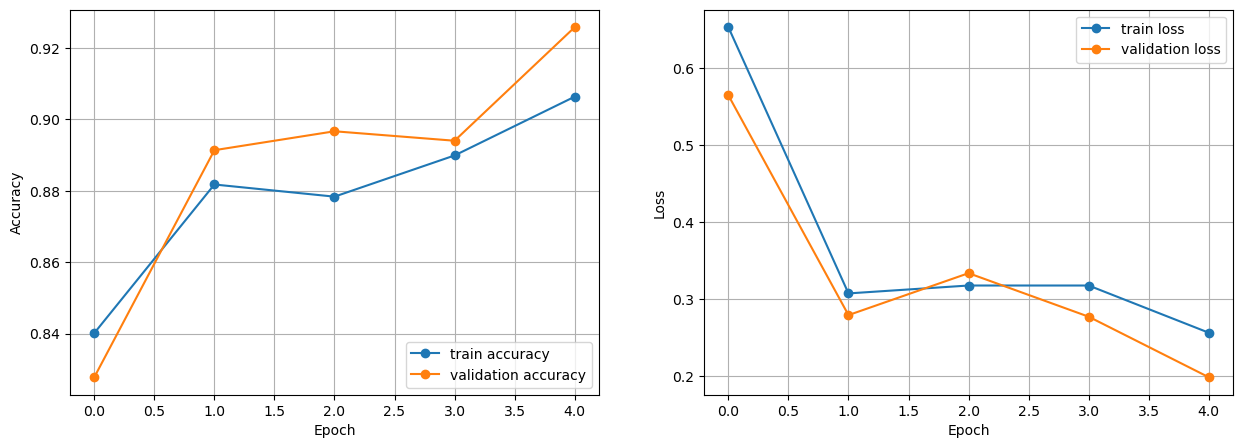

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [17]:
test_loss, test_acc = model.evaluate(X_test_norm, y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)
model.save('face-musk-model.h5')


48/48 [==============================] - 21s 447ms/step - loss: 0.1834 - accuracy: 0.9252

Test Accuracy: 0.9251655340194702

Test Loss: 0.18335068225860596
